Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/sem4_project/darknet

/content/drive/MyDrive/sem4_project/darknet


In [ ]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

Using Yolo model pretrained weights to train model

In [ ]:
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

In [ ]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0
 
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3_1.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [ ]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from PIL import Image

Bounding_boxes_manipulation

In [ ]:
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
    
	return v_boxes, v_labels, v_scores
def padding(image,v_boxes):
    width, height = image.size
    result = image
    if width <= 299 and height <= 299 :
        result = Image.new(image.mode, (299, 299), 'white')
        result.paste(image, ((299//2)-(width//2), (299//2)-(height//2)))
    elif width <= 299:
        result = Image.new(image.mode, (299, height), 'white')
        result.paste(image, ((299//2)-(width//2), 0))
    elif height <= 299:
        result = Image.new(image.mode, (width, 299), 'white')
        result.paste(image, (0, (299//2)-(height//2)))
    pyplot.imshow(result)
    pyplot.show()
    return result

def draw_boxes(filename, v_boxes, v_labels, v_scores):
    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='red')
    pyplot.show()
    	
    im = np.array(Image.open(filename))
    
    # print("Before trimming:",im.shape)
    for i in range(len(v_boxes)):
        try:
            #print(v_boxes[i].ymin,v_boxes[i].ymax,v_boxes[i].xmin,v_boxes[i].xmax)
            if(v_boxes[i].ymin < 0):
                v_boxes[i].ymin = 0
            elif(v_boxes[i].xmin < 0):
                v_boxes[i].xmin = 0
            elif(v_boxes[i].ymax < 0):
                v_boxes[i].ymax = 0
            elif(v_boxes[i].xmax < 0):
                v_boxes[i].xmax = 0
            im_trim = im[v_boxes[i].ymin:v_boxes[i].ymax,v_boxes[i].xmin:v_boxes[i].xmax]
            # print("After trimming:",im_trim.shape)
            
            # pyplot.imshow(im_trim)
            # pyplot.show()

            if(v_labels[i] == "person"):
                img = Image.fromarray(im_trim,'RGB')

                #img_2 = padding(img,v_boxes)
                #print(img_2.shape)
                #img_1 = cv2.imread(img)

                img_1 = np.asarray(img)
                fe = face_extractor(img_1)
       
                pyplot.imshow(fe)
                pyplot.show()
                # model_pred(fe)
                siamese(fe)
            else:
                pyplot.imshow(im_trim)
                pyplot.show()
                print("**"+v_labels[i]+"**")
        except:
            pass

Load_inception_model

In [ ]:
model_1 = load_model('/content/drive/MyDrive/model/model_high_acc_5_4_21.h5')

Cropping_face

In [ ]:
import cv2
import numpy as np

# Load HAAR face classifier
#face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
# Load functions
def face_extractor(img):
    # Function detects faces and returns the cropped face
    # If no face detected, it returns the input image
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(img, 1.3, 5)
    if faces is ():
        return img
    # Crop all faces found
    for (x,y,w,h) in faces:
        x=x-10
        y=y-10
        cropped_face = img[y:y+h+50, x:x+w+50]
    return cropped_face

Predict_function

In [ ]:
model_a = Model(model_1.inputs, model_1.layers[-2].output)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Image_pred_res/all.txt','rb') as fp:
    final_pred_list_1 = pickle.load(fp)

In [ ]:
def img_pred(image1):
    face1 = np.asarray(image1)    
    face1 = cv2.resize(face1, (224,224))
    img_array1 = np.array(face1) 
    img_array1 = img_array1/255
    img_array1 = np.expand_dims(img_array1, axis=0)
    pred = model_a.predict(img_array1)
    return pred

In [ ]:
def siamese(img):
    cnt = 0
    thresholds = {'gates': 59.36999999999676,'jack': 38.780000000000854,'modi': 73.05000000000047,'musk':37.58000000000109,'trump': 48.5999999999989}
    th = {}

    for (p,q),(i,j) in zip(thresholds.items(),final_pred_list_1.items()):
        t_l = np.sum(np.absolute(img_pred(img)-j))
        if q > t_l:
            th[p] = t_l

    indx = ''
    if len(th) > 1:
        min = 1000
        for i,j in th.items():
            if min > j:
                min = j
                indx = i
        print(indx,min)
        print(th)   
        if h == str(indx):
            cnt+=1
    else:
        print(th)

In [ ]:
import cv2
from PIL import Image
import numpy as np
def model_pred(img):
    
    #testing = cv2.imread('/content/drive/MyDrive/Five_Faces/test/jack/jack137.jpg')

    face = img
    #print(face.shape)
    face = cv2.resize(face, (224,224))
    #print(face.shape)
    im = Image.fromarray(face, 'RGB')
    #Resizing into 128x128 because we trained the model with this image size.
    img_array = np.array(im) 
    img_array = img_array/255
    #Our keras model used a 4D tensor, (images x height x width x channel)
    #So changing dimension 128x128x3 into 1x128x128x3 
    img_array = np.expand_dims(img_array, axis=0)
    pred = model_1.predict(img_array)
    print(pred)
    a=np.argmax(pred, axis=1)
    if(pred[0][a] > 0.9):
        #print(a)
        if(a==0):
            print("***Bill Gates***")
        elif(a==1):
            print("***Jack Ma***")
        elif(a==2):
            print("***Narendra Modi***")
        elif(a==3):
            print("***Elon_musk***")
        elif(a==4):
            print("***Donald trump***")
    else:
        print("***Unknown person***")

Define the labels

In [ ]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

Load yolov3 model

In [ ]:
import time
model = load_model('model.h5')

Prediction of input image

Seconds since epoch = 0.0994880199432373
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
Seconds since epoch = 0.3459639549255371
Seconds since epoch = 1.9676494598388672
Seconds since epoch = 1.1629536151885986
person 98.18933606147766 2 39 269 378
person 99.74004030227661 246 83 553 392
tie 98.15712571144104 119 240 189 375


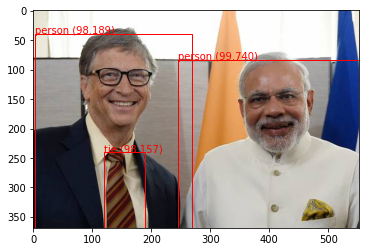

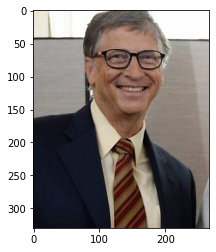

{'gates': 8.650753}


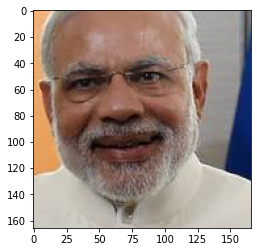

{'modi': 19.721523}


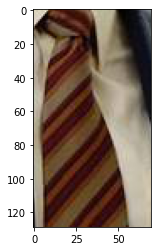

**tie**
Seconds since epoch = 1.1503596305847168


In [ ]:
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/content/drive/MyDrive/Testing_set/modi_gates.jpg'
# load and prepare image
seconds = time.time()
#print("Seconds since epoch =", seconds)	

image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
seconds1 = time.time()
print("Seconds since epoch =", seconds1-seconds)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
seconds2 = time.time()
print("Seconds since epoch =", seconds2-seconds1)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
seconds3 = time.time()
print("Seconds since epoch =", seconds3-seconds2)
# get the details of the detected objects

v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
seconds4 = time.time()
print("Seconds since epoch =", seconds4-seconds3)
# summarize what we found
#print(list(v_boxes))
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],v_boxes[i].xmin,v_boxes[i].ymin,v_boxes[i].xmax,v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
seconds5 = time.time()
print("Seconds since epoch =", seconds5-seconds4)

Simese

In [ ]:
from keras.models import load_model
from keras.models import Model
from keras import layers
import cv2

Load Inception Model

In [ ]:
smodel1 = load_model('/content/drive/MyDrive/model/model_high_acc_5_4_21.h5')

In [ ]:
smodel1.summary()

In [ ]:
# count = 0
# u = 0
# for i in m:
#     h = i.split('/')[-2]
#     if h == 'gates': u = 0
#     elif h == 'jack': u = 1
#     elif h == 'modi': u = 2
#     elif h == 'musk': u = 3
#     elif h == 'trump': u = 4
#     else :u = 5
#     print(u)
#     testing = cv2.imread(i)
#     face = testing
#     #print(face.shape)
#     face = cv2.resize(face, (224,224))
#     #print(face.shape)
#     im = Image.fromarray(face, 'RGB')
#     #Resizing into 128x128 because we trained the model with this image size.
#     img_array = np.array(im) 
#     img_array = img_array/255
#     #Our keras model used a 4D tensor, (images x height x width x channel)
#     #So changing dimension 128x128x3 into 1x128x128x3 
#     img_array = np.expand_dims(img_array, axis=0)
#     pred = smodel1.predict(img_array)
#     a=np.argmax(pred, axis=1)
#     print(a)
#     if(a == u):
#         count +=1
# print("acc :",(count / (len(m)))* 100)

In [ ]:
model_a = Model(smodel1.inputs, smodel1.layers[-2].output)

In [ ]:
model_a.summary()

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/Image_pred_res/trump.txt','rb') as fp:
#     final_pred_list['trump'].append(pickle.load(fp))

In [ ]:
# print(final_pred_list)

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/Image_pred_res/all.txt','wb') as fp:
#     pickle.dump(final_pred_list,fp)

In [ ]:
# type(final_pred_list_1)

In [ ]:
final_pred_list = {'gates':[],'jack':[],'modi':[],'musk':[],'trump':[]}

In [ ]:
import pickle
with open('/content/drive/MyDrive/Image_pred_res/all.txt','rb') as fp:
    final_pred_list_1 = pickle.load(fp)

In [ ]:
import os
path = '/content/drive/MyDrive/Five_faces_cropped/test/'
m = []
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        name = str(os.path.join(dirpath,filename))
        m.append(name)
m

In [ ]:
# m[0].split('/')

In [ ]:
def img_pred(image1):
    face1 = np.asarray(image1)    
    face1 = cv2.resize(face1, (224,224))
    img_array1 = np.array(face1) 
    img_array1 = img_array1/255
    img_array1 = np.expand_dims(img_array1, axis=0)
    pred = model_a.predict(img_array1)
    return pred

In [ ]:
# On test set
# thresholds = {'gates': 56.209999999997386,'jack': 36.08000000000139,'modi': 58.49999999999693,'musk':40.47000000000052,'trump': 42.450000000000124}

In [ ]:
# final_pred_list_1['gates']

Calculate avg_final_pred

In [ ]:
final_pred_sum = np.zeros((1,1,64))
for (i,j) in final_pred_list_1.items():   
    final_pred_sum += j

In [ ]:
print(final_pred_sum)

In [ ]:
avg_final_pred_list = {}
for i,j in final_pred_list_1.items():
    avg_final_pred_list[i] = np.divide(j, final_pred_sum, out=np.zeros_like(j), where=final_pred_sum!=0)

In [ ]:
# print(avg_final_pred_list['gates'].shape)

Join siamese to yolo

In [ ]:
cnt = 0
for r in li:
    b = im.fromarray(r)
    img = b
    th = {}

    for (p,q),(i,j) in zip(thresholds.items(),final_pred_list_1.items()):
        t_l = np.sum(np.absolute(img_pred(img)-j))
        if q > t_l:
            th[p] = t_l

    indx = ''
    if len(th) > 1:
        min = 1000
        for i,j in th.items():
            if min > j:
                min = j
                indx = i
        print(indx,min)
        print(th)   
        if h == str(indx):
            cnt+=1
    else:
        print(th)

{'gates': 56.32624}
{'jack': 20.593992}
{'modi': 50.31059}


Average final_pred

In [ ]:
#On avg train thresholds
# thresholds = {'gates': 12.639999999999775,'jack': 6.2799999999999105,'modi': 13.069999999999766,'musk': 7.919999999999876,'trump': 10.479999999999821}

In [ ]:
cnt = 0
for b in m:
    h = b.split('/')[-2]
    img = load_img(b) 
    th = {}

    for (p,q),(i,j) in zip(thresholds.items(),avg_final_pred_list.items()):
        k = img_pred(img)
        k = np.resize(k,(1,1,64))
        t_l = np.sum(np.absolute(np.divide(k,np.resize(final_pred_sum,(1,64)), out=np.zeros_like(k), where=final_pred_sum!=0)-j))
        if q > t_l:
            th[p] = t_l

    indx = ''
    if len(th) > 1:
        min = 1000
        for i,j in th.items():
            if min > j:
                min = j
                indx = i
        print(indx,min)
        print(th)   
        if h == str(indx):
            cnt+=1
    else:
        print(th)
        for i in th.keys():
            if h == str(i):
                cnt+=1
print((cnt/len(m))*100)

Normal final pred

In [ ]:
#train thresholds
# thresholds = {'gates': 59.36999999999676,'jack': 38.780000000000854,'modi': 73.05000000000047,'musk':37.58000000000109,'trump': 48.5999999999989}

In [ ]:
cnt = 0
for b in m:
    h = b.split('/')[-2]
    img = load_img(b)
    th = {}

    for (p,q),(i,j) in zip(thresholds.items(),final_pred_list_1.items()):
        t_l = np.sum(np.absolute(img_pred(img)-j))
        if q > t_l:
            th[p] = t_l

    indx = ''
    if len(th) > 1:
        min = 1000
        for i,j in th.items():
            if min > j:
                min = j
                indx = i
        print(indx,min)
        print(th)   
        if h == str(indx):
            cnt+=1
    else:
        print(th)
        for i in th.keys():
            if h == str(i):
                cnt+=1
print((cnt/len(m))*100)

Find threshold

In [ ]:
for_gates = {'gates':[],'jack':[],'modi':[],'musk':[],'trump':[]}

In [ ]:
import pickle
with open('/content/drive/MyDrive/Image_pred_res/gates.txt','rb') as fp:
    final_pred = pickle.load(fp)

In [ ]:
for i in m:
    img = load_img(i)
    t = np.absolute(img_pred(img)-final_pred)
    for_gates[i.split('/')[-2]].append(np.sum(t))
print(for_gates)

{'gates': [66.289314, 55.61285, 63.508305, 70.241425, 56.01784, 76.46352, 111.54165, 99.5804, 97.888794, 134.25743, 54.40175, 63.242126, 92.52089, 92.16683, 68.11514, 115.61623, 87.56987, 81.76305, 64.28392, 91.83942, 81.61278, 121.574066, 78.916824, 74.19156, 85.888596, 81.76305, 125.1924, 88.11958, 94.98116, 77.353714, 106.48602, 52.456963, 95.24906, 69.57093, 74.064316, 80.604294, 97.61576, 80.55749, 78.152534, 60.565514, 68.4727, 80.75888, 102.94815, 83.94179, 79.62854, 66.62306, 66.82503, 87.485, 59.610664, 84.3096, 59.002373, 55.2422, 65.48697, 61.0119, 60.86222, 74.854614, 78.5546, 84.75692, 62.094406, 67.01074, 87.64833, 54.381252, 60.47787, 75.59126, 73.908356, 83.203896, 56.263268, 122.42531, 72.84296, 67.08299, 77.42314, 76.51863], 'jack': [66.54288, 68.55788, 72.98965, 83.13266, 82.216515, 70.9041, 81.76117, 66.435074, 67.35641, 57.952984, 75.672104, 81.520874, 52.782623, 92.02915, 73.408035, 70.56503, 68.55003, 106.079926, 79.86579, 70.92862, 120.71497, 85.339905, 57.14441

In [ ]:
# import os
# path = '/content/drive/MyDrive/Five_faces_cropped/train/'
# all_train = []
# for (dirpath, dirnames, filenames) in os.walk(path):
#     for filename in filenames:
#         name = str(os.path.join(dirpath,filename))
#         all_train.append(name)
# all_train

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/Image_pred_res/all_avg.txt','wb') as fp:
#     pickle.dump(avg_final_pred_list,fp)

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/Image_pred_res/trump.txt','rb') as fp:
#     final_pred_new = pickle.load(fp)

In [ ]:
# for_gates = {'gates':[],'jack':[],'modi':[],'musk':[],'trump':[]}

In [ ]:
# for i in all_train:
#     img = load_img(i)
#     j = img_pred(img)
#     t = np.absolute(np.divide(j,np.resize(final_pred_sum,(1,64)), out=np.zeros_like(j), where=final_pred_sum!=0)-avg_final_pred_list['trump'])
#     for_gates[i.split('/')[-2]].append(np.sum(t))
# print(for_gates)

{'gates': [12.260709, 15.271748, 10.839451, 13.701592, 16.606834, 12.010912, 11.046243, 19.347845, 13.856274, 10.298573, 17.984558, 12.078135, 15.503869, 17.665394, 13.150798, 14.935844, 48.635635, 67.60042, 12.3419075, 15.61593, 14.869951, 22.651257, 19.58182, 17.556427, 16.780298, 13.868593, 19.33086, 29.50026, 13.334659, 16.299898, 15.459007, 13.014797, 17.589561, 14.979583, 14.40413, 18.051, 18.917637, 14.517318, 61.65187, 31.616419, 13.867256, 11.512156, 13.860936, 17.400814, 14.92634, 15.390627, 15.593359, 19.260956, 29.062819, 13.2859745, 19.28843, 19.160675, 15.751724, 13.180478, 18.474844, 23.999416, 17.589561, 15.61593, 15.517062, 19.347845, 31.616419, 20.860846, 18.650738, 15.593359, 17.984558, 13.014797, 13.5136795, 12.258045, 13.819381, 18.474844, 14.533285, 18.637192, 61.65187, 14.607258, 19.58182, 17.400814, 15.865139, 13.857875, 29.50026, 18.659826, 21.15586, 14.050197, 20.761837, 14.869951, 21.572021, 16.407614, 13.2859745, 14.935844, 16.530842, 13.868593, 17.690067, 1

In [ ]:
x=0
pre_acc = 0
cur_acc = 1
max = 0
x0 = 0
while x<100:
    # pre_acc = cur_acc
    g_ct = 0
    for i in for_gates['trump']:
        if(i < x):
            g_ct+=1
    ng_ct = 0
    len_ng = 0
    for i,j in for_gates.items():
        if i != 'trump':
            for k in j:
                if(k > x):
                    ng_ct+=1
                len_ng+=1
    cur_acc = ((g_ct + ng_ct)/(len(for_gates['trump']) + (len_ng))) * 100
    if max < cur_acc:
        max = cur_acc
        x0 = x
    x += 0.01
print(max,x0)

98.73695771554091 10.479999999999821


On tain set
1.   gates: 98.13289401427787 12.639999999999775
2.   jack: 98.68204283360791 6.2799999999999105
3.   modi: 99.34102141680395 13.069999999999766
4.   musk: 97.74848984074684 7.919999999999876
5.   trump: 98.73695771554091 10.479999999999821

On tain set
1.   gates: 99.34102141680395 59.36999999999676
2.   jack: 98.46238330587589 38.780000000000854
3.   modi: 99.39593629873696 73.05000000000047
4.   musk: 98.90170236133993 37.58000000000109
5.   trump: 98.79187259747391 48.5999999999989



On test set
1.   gates: 97.45370370370371  56.209999999997386
2.   jack: 96.29629629629629   36.08000000000139
3.   modi: 99.30555555555556   58.49999999999693
4.   musk: 97.22222222222221   40.47000000000052
5.   trump: 97.45370370370371  42.450000000000124



In [ ]:
g_ct = 0
for i in for_gates['gates']:
    if(i < 41.040000000000404):
        g_ct+=1
acc = (g_ct/len(for_gates['gates']) ) * 100
print(acc)

55.092592592592595


In [ ]:
ng_ct = 0
len_ng = 0
x = 41.040000000000404
for i,j in for_gates.items():
    if i != 'gates':
        for k in j:
            if(k > x):
                ng_ct+=1
            len_ng+=1
acc1 = (ng_ct/len_ng)* 100
print(acc1)

91.75925925925927


In [ ]:
# for i in m:
#     a = i.split('/')
#     dictn[a[-2]]

In [ ]:
test_list_1 = []
for i in m:
    img = load_img(i)
    t = np.absolute(img_pred(img)-final_pred)
    test_list_1.append(np.sum(t))
print(min(test_list_1),max(test_list_1))

5.536845 191.3732


In [ ]:
print(sum(test_list_1)/len(test_list_1))

21.21375493473477


In [ ]:
count = 0
for i in test_list_1:
    if(i < 50):
        count+=1
print(count)

85


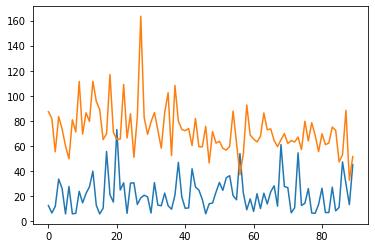

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_list_1)
plt.plot(temp)
plt.show()

Final_pred_calulation

In [ ]:
# import os
# path = '/content/drive/MyDrive/Five_faces_cropped/train/trump/'
# n = []
# for (dirpath, dirnames, filenames) in os.walk(path):
#     for filename in filenames:
#         name = str(os.path.join(dirpath,filename))
#         n.append(name)
# n

In [ ]:
# from keras.preprocessing.image import load_img
# image1 = load_img('/content/drive/MyDrive/Five_faces_cropped/test/gates/gates10.jpg')
# image2 = load_img('/content/drive/MyDrive/Five_faces_cropped/test/gates/gates116.jpg')
# print(image1.size)
# print(image2.size)

(230, 230)
(164, 164)


In [ ]:
img_pred_list = []
for i in n:
    img = load_img(i)
    img_pred_list.append(img_pred(img))

In [ ]:
print(sum(img_pred_list))

[[1.9615781e+00 4.3219442e+00 0.0000000e+00 5.2282629e+02 2.7027612e+02
  9.0286151e+02 8.3014789e+02 2.2390997e+00 1.5526660e+01 1.6424094e+02
  5.4529016e+02 4.5750640e-02 7.9340992e+00 7.8114606e+02 7.1833181e+00
  1.0060780e+03 3.8382664e+01 1.4601644e+03 1.2619507e+02 0.0000000e+00
  1.1988502e+02 1.3627480e+02 6.5665993e+01 1.0152907e+03 7.8534186e+02
  0.0000000e+00 3.9480853e+02 1.1098816e+03 5.8911578e+02 4.8704279e+02
  2.5704086e+02 8.2622919e+02 1.3142528e+03 9.5146484e+02 4.5782953e+02
  0.0000000e+00 6.9703577e+02 1.5119351e+03 5.3950684e+02 3.3792355e+01
  5.2543407e+01 8.3502312e+00 0.0000000e+00 1.3395856e+03 1.2225570e+02
  2.2620154e+02 1.8335853e+03 5.3921533e+02 9.2064978e+02 3.9871791e-01
  7.3915283e+02 0.0000000e+00 0.0000000e+00 1.0643687e+03 1.0597537e+01
  2.6519761e+03 1.1162192e+03 1.4612772e+02 3.5342038e+02 4.7672354e+02
  0.0000000e+00 3.6143103e+02 1.2356161e+00 0.0000000e+00]]


In [ ]:
final_pred = sum(img_pred_list) / len(n)
print(final_pred)

[[5.0950083e-03 1.1225829e-02 0.0000000e+00 1.3579904e+00 7.0201588e-01
  2.3450949e+00 2.1562283e+00 5.8158436e-03 4.0328987e-02 4.2659983e-01
  1.4163381e+00 1.1883283e-04 2.0608051e-02 2.0289507e+00 1.8657969e-02
  2.6131897e+00 9.9695228e-02 3.7926350e+00 3.2777941e-01 0.0000000e+00
  3.1138965e-01 3.5396051e-01 1.7056102e-01 2.6371188e+00 2.0398490e+00
  0.0000000e+00 1.0254767e+00 2.8828094e+00 1.5301709e+00 1.2650462e+00
  6.6763860e-01 2.1460497e+00 3.4136436e+00 2.4713373e+00 1.1891676e+00
  0.0000000e+00 1.8104825e+00 3.9271040e+00 1.4013164e+00 8.7772347e-02
  1.3647638e-01 2.1688912e-02 0.0000000e+00 3.4794431e+00 3.1754726e-01
  5.8753645e-01 4.7625594e+00 1.4005593e+00 2.3912981e+00 1.0356309e-03
  1.9198775e+00 0.0000000e+00 0.0000000e+00 2.7645938e+00 2.7526069e-02
  6.8882494e+00 2.8992708e+00 3.7955251e-01 9.1797501e-01 1.2382430e+00
  0.0000000e+00 9.3878192e-01 3.2093925e-03 0.0000000e+00]]


In [ ]:
# import pickle
# with open('/content/drive/MyDrive/Image_pred_res/trump.txt','wb') as fp:
#     pickle.dump(final_pred,fp)

In [ ]:
print(fin_pred_bill)

[[0.0000000e+00 3.5576322e+00 0.0000000e+00 5.1972456e-03 0.0000000e+00
  1.2313088e+00 5.0590153e+00 1.8668671e+00 0.0000000e+00 2.0969477e+00
  1.1720346e+00 0.0000000e+00 0.0000000e+00 3.3082402e+00 7.3833689e-02
  3.5670183e+00 7.7679369e-04 4.0269741e-01 0.0000000e+00 0.0000000e+00
  6.7624711e-03 3.7688071e-01 1.4275852e+00 1.5373503e-02 1.1035168e+00
  0.0000000e+00 2.1435346e-03 3.4315329e+00 1.0807613e+00 8.3418749e-02
  1.1475953e+00 4.0337790e-02 2.6206944e+00 3.4601123e+00 3.8050618e-03
  0.0000000e+00 3.2082365e+00 6.1578196e-03 1.4851440e-01 1.8518815e+00
  3.1302094e+00 1.7482063e+00 0.0000000e+00 3.0114186e-01 3.0513075e-01
  1.6747788e+00 3.9658103e+00 1.7124447e-01 5.6197629e+00 0.0000000e+00
  1.3252460e+00 5.6556710e-05 5.0663017e-04 1.4277152e+00 1.7795370e+00
  3.8014488e+00 1.1497065e+00 0.0000000e+00 0.0000000e+00 2.9923787e+00
  0.0000000e+00 6.7512828e-01 0.0000000e+00 0.0000000e+00]]


In [ ]:
import cv2
from PIL import Image
import numpy as np

In [ ]:
image2 = load_img('/content/drive/MyDrive/Five_faces_cropped/test/musk/musk196.jpg')

In [ ]:
face1 = np.asarray(image1)    
face1 = cv2.resize(face1, (224,224))
img_array1 = np.array(face1) 
img_array1 = img_array1/255
img_array1 = np.expand_dims(img_array1, axis=0)
print(img_array1.shape)

(1, 224, 224, 3)


In [ ]:
face2 = np.asarray(image2)    
face2 = cv2.resize(face2, (224,224))
img_array2 = np.array(face2) 
img_array2 = img_array2/255
img_array2 = np.expand_dims(img_array2, axis=0)
print(img_array2.shape)

(1, 224, 224, 3)


In [ ]:
pred = model_a.predict(img_array1)

In [ ]:
print(pred)

[[0.         2.1780384  0.         0.         0.         1.3485739
  2.8479319  1.2985232  0.         0.6026008  1.9951555  0.
  0.         1.8527775  0.         2.8269665  0.         0.
  0.         0.         0.         0.43915403 0.43190363 0.32004017
  0.35661274 0.         0.33028182 2.8140094  0.58055717 0.75249696
  0.3225096  0.6167195  1.6285831  1.3124278  0.         0.
  1.3195161  0.8523749  0.08509376 2.3434157  0.71439826 0.5524283
  0.         1.3052131  1.3438754  0.04194461 2.26534    0.9202126
  2.1860344  0.         0.33354482 0.         0.         0.5364174
  0.03395996 2.7105758  0.         0.         0.         3.1748455
  0.         1.320068   0.         0.        ]]


In [ ]:
pred1 = model_a.predict(img_array2)

In [ ]:
print(pred1)

[[0.         1.2593725  0.         1.2045124  0.         2.9869726
  2.3801994  0.         0.         4.095041   0.6834807  0.
  0.         2.5528824  1.2882069  1.8171756  0.         2.8074775
  0.         0.         0.         0.13715312 0.2750858  0.
  2.0736206  0.         0.         1.7969432  0.7375701  0.
  0.         1.518415   0.33713132 1.9508609  1.1875782  0.
  3.251381   0.         0.18190762 0.         1.3180367  0.
  0.         0.         2.8383725  1.3744715  1.7348192  0.20332122
  5.420897   0.         0.59721524 0.         0.         0.67598516
  3.8010855  0.6780929  1.0106997  0.         0.         0.52424175
  0.         0.         0.         0.        ]]


In [ ]:
result = np.absolute(pred1 - final_pred)

In [ ]:
print(result)

[[7.55629456e-03 2.40227079e+00 0.00000000e+00 6.98372483e-01
  1.30509995e-02 1.94052935e-01 1.75508332e+00 2.18267798e+00
  1.78504443e+00 2.96583867e+00 3.55190468e+00 2.62974715e-03
  2.74828100e+00 3.74384642e-01 1.27991700e+00 1.90534854e+00
  5.78791041e-05 2.72333264e+00 1.10025704e-02 0.00000000e+00
  0.00000000e+00 2.97317535e-01 2.64591992e-01 1.31869279e-02
  2.03495741e+00 5.91226760e-03 2.65043855e+00 1.88290310e+00
  1.22349858e-02 1.31449604e+00 9.85505521e-01 2.32070279e+00
  3.20356935e-01 1.93396711e+00 4.86391902e-01 1.01312203e-02
  3.00806856e+00 4.89193964e+00 1.73300296e-01 3.29871321e+00
  1.30936718e+00 0.00000000e+00 6.75270930e-02 2.96791410e+00
  3.02092290e+00 1.37091339e+00 8.94890904e-01 3.07340193e+00
  4.97224188e+00 1.65763416e-03 5.94318211e-01 7.05401301e-01
  4.48158971e-05 6.39544010e-01 2.35702300e+00 1.91491604e-01
  1.00617039e+00 8.53241682e-02 1.53241622e+00 4.31743383e+00
  0.00000000e+00 1.81391954e+00 8.72813538e-03 1.25126261e-03]]


In [ ]:
np.sum(result)

81.43782

after

In [ ]:
from tensorflow.keras.layers import Dense

left_input = tf.keras.Input(pred.shape)
right_input = tf.keras.Input(pred1.shape)

L1_layer = tf.keras.layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([pred, pred1])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid')(L1_distance)

# Connect the inputs with the outputs
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

ValueError: ignored

In [ ]:
import tensorflow as tf
from keras import backend as K
left_input = tf.keras.Input(img_array.shape)
right_input = tf.keras.Input(img_array.shape)

encoded_l = model_a(left_input)
encoded_r = model_a(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)

# Connect the inputs with the outputs
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

ValueError: ignored

In [ ]:
l = [array([[1,2,3,4,5]]),array([[7,6,8,9,12]])]
sum(l)

NameError: ignored